## Downsampling analysis

In [71]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, spearmanr, ttest_ind, levene, f_oneway, ttest_1samp, skewtest
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import csv
from statsmodels import robust
import matplotlib.gridspec as gridspec
from statsmodels.formula.api import ols
import statsmodels.api as sm
import warnings
import collections
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True, font_scale=2)
snsRed, snsBlue, snsGreen, snsPurple, snsOrange = sns.color_palette("Set1", n_colors=5, desat=.5)
snsGray = sns.color_palette("Set1", n_colors=9, desat=.5)[8]

### Define data locations

In [72]:
skr_weinberg_gene = "../Data/skr_weinberg_genesTE.csv"
skr_weinberg_downsample_prefix = "/seq/schatz/hfang/Projects/RiboSeq/Weinberg_2015/new_te_analysis/downSampling/"
protein_quant = "../Data/Lawless_2016.csv.cleaned.csv"

skr_weinberg_codon =  "../Data/skr_weinberg_codons.csv"

skr_McManus_gene = "/seq/schatz/hfang/Projects/RiboSeq/McManus_2014/te_analysis/SRR948553/genesTE.csv"
skr_McManus_codon = "/seq/schatz/hfang/Projects/RiboSeq/McManus_2014/te_analysis/SRR948553/codons.csv"
weinberg_kallisto_rna = "../Data/kallisto_rnaseq_abundance.tsv"
McManus_kallisto_rna = "/seq/schatz/hfang/Projects/RiboSeq/McManus_2014/quantification/kallisto/SRR948551/abundance.tsv"


In [73]:
gene_dfs, codon_dfs = {}, {}
te_files = [skr_McManus_gene, skr_weinberg_gene, weinberg_kallisto_rna, McManus_kallisto_rna, protein_quant]
for te_file in te_files:
    gene_dfs[te_file] = pd.read_table(te_file, header=0)

codon_dfs[skr_weinberg_codon] = pd.read_table(skr_weinberg_codon, header=0)
codon_dfs[skr_McManus_codon] = pd.read_table(skr_McManus_codon, header=0)

down_sampled_fractions = np.round(np.arange(0.1, 1.0, 0.1), 1)
reps = np.round(np.arange(1.0, 4.0, 1.0),0)
for i in reps:
    for j in down_sampled_fractions:
        par = i+j
        gene_dfs[par] = pd.read_table(skr_weinberg_downsample_prefix + str(par) + "/genesTE.csv", header=0)
        codon_dfs[par] =  pd.read_table(skr_weinberg_downsample_prefix + str(par) + "/codons.csv", header=0)

kallisto_rna = pd.merge(gene_dfs[weinberg_kallisto_rna], gene_dfs[McManus_kallisto_rna], 
                        on="target_id", suffixes=["_weinberg","_McManus"])


In [74]:
gene_corrs, codon_corrs = [], []
for i in reps:
    gene_lst, codon_lst = [], []
    for j in down_sampled_fractions:
        par = i+j
        gene_downSampled = gene_dfs[par].copy()
        gene_df = pd.merge(gene_dfs[skr_weinberg_gene], gene_downSampled, on ="gene", 
                      suffixes=["_original","_downsampled"])
        gene_corr = round(pearsonr(gene_df["log2_TE_original"], gene_df["log2_TE_downsampled"])[0], 2)
        gene_lst.append(gene_corr)
        codon_downSampled = codon_dfs[par].copy()
        codon_df = pd.merge(codon_dfs[skr_weinberg_codon], codon_downSampled, on ="codon", 
                      suffixes=["_original","_downsampled"])
        codon_corr = round(pearsonr(codon_df["codon_dwell_time_original"], 
                                    codon_df["codon_dwell_time_downsampled"])[0], 2)
        codon_lst.append(codon_corr)
    gene_corrs = gene_corrs + gene_lst
    codon_corrs = codon_corrs + codon_lst

fractions = list(down_sampled_fractions) * 3
replicates = [i for i in reps for j in down_sampled_fractions]
gene_lst = [gene_corrs, fractions, replicates]
gene_df = pd.DataFrame(gene_lst).T

gene_df.rename(columns={0:"correlation", 1:"fraction", 2:"replicate"}, inplace=True)
gene_df["num_reads"] = gene_df["fraction"] * 77
avg_gene_df = gene_df.groupby("num_reads")['correlation'].mean().reset_index()

codon_lst = [codon_corrs, fractions, replicates]
codon_df = pd.DataFrame(codon_lst).T
codon_df.rename(columns={0:"correlation", 1:"fraction", 2:"replicate"}, inplace=True)
codon_df["num_reads"] = codon_df["fraction"] * 77

avg_codon_df = codon_df.groupby("num_reads")['correlation'].mean().reset_index()

In [75]:
chx_gene_df = pd.merge(gene_dfs[skr_weinberg_gene], gene_dfs[skr_McManus_gene], on ="gene", 
              suffixes=["_weinberg","_McManus"])
chx_codon_df = pd.merge(codon_dfs[skr_weinberg_codon], codon_dfs[skr_McManus_codon], on ="codon", 
              suffixes=["_weinberg","_McManus"])

chx_gene_corr = round(pearsonr(chx_gene_df["log2_TE_weinberg"], chx_gene_df["log2_TE_McManus"])[0], 2)
chx_codon_corr = round(pearsonr(chx_codon_df["codon_dwell_time_weinberg"], chx_codon_df["codon_dwell_time_McManus"])[0], 2)


In [76]:
chx_gene_df_tpm = pd.merge(chx_gene_df, kallisto_rna, left_on="gene", right_on="target_id")
skr_high_abundance = chx_gene_df_tpm[chx_gene_df_tpm["tpm_weinberg"] > 10]
skr_high_abundance_gene_corr = round(pearsonr(skr_high_abundance["log2_TE_weinberg"], 
                                              skr_high_abundance["log2_TE_McManus"])[0], 2)


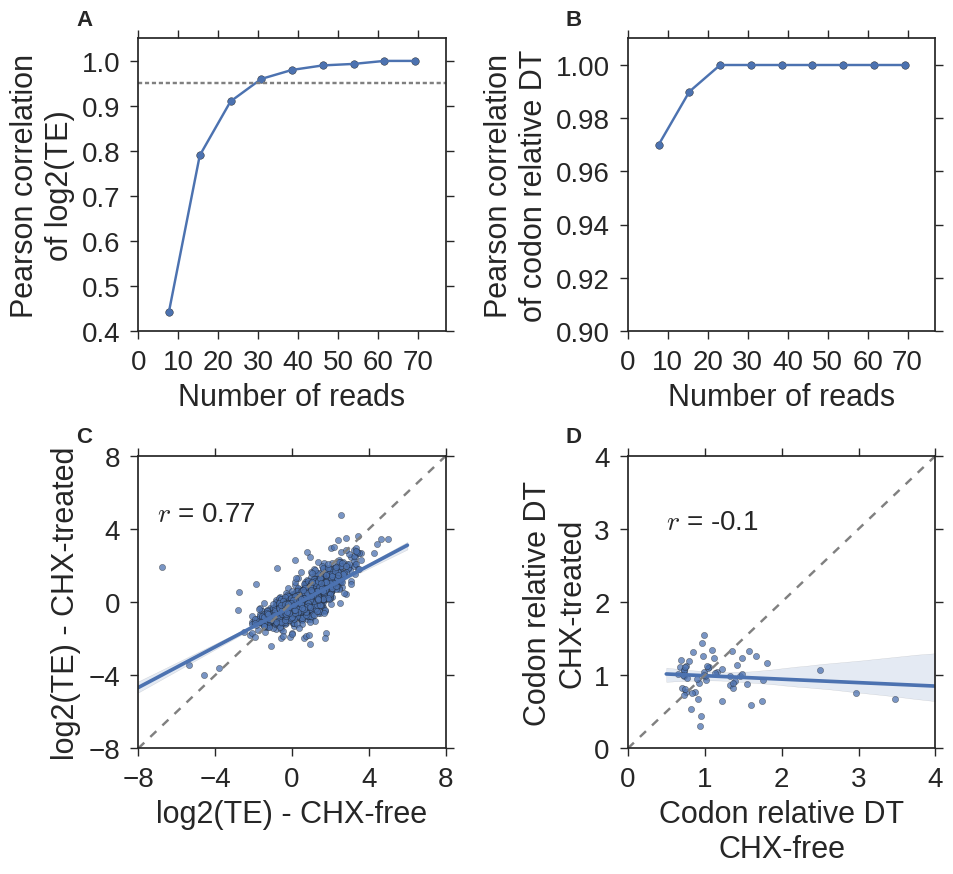

In [77]:
fig = plt.figure(figsize=(10, 9))

ax1 = plt.subplot(2, 2, 1)

ax1 = sns.tsplot(time="num_reads", value="correlation", unit="replicate", err_style="ci_bars", data=gene_df)
ax1.scatter(avg_gene_df["num_reads"], y=avg_gene_df["correlation"], s=30)

ax1.axhline(y=0.95, xmin=0, xmax=70, dashes=[3,2], color="gray")

ax1.set_xlabel("Number of reads")
ax1.set_ylabel("Pearson correlation\nof log2(TE)")
plt.ylim(0.4,1.05)
plt.xlim(0,77)
ax1.text(-0.15, 1.1, "A", transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(2, 2, 2)

ax2 = sns.tsplot(time="num_reads", value="correlation", unit="replicate", err_style="ci_bars", data=codon_df)
ax2.scatter(avg_codon_df["num_reads"], y=avg_codon_df["correlation"], s=30)

# ax.axhline(y=0.95, xmin=0, xmax=70, dashes=[3,2], color="gray")
ax2.set_xlabel("Number of reads")
ax2.set_ylabel("Pearson correlation\nof codon relative DT")
plt.ylim(0.9,1.01)
plt.xlim(0,77)
ax2.text(-0.15, 1.1, "B", transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(2, 2, 3)

ax3.scatter(x="log2_TE_weinberg", y="log2_TE_McManus", data=skr_high_abundance, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_TE_weinberg", y="log2_TE_McManus", data=skr_high_abundance, scatter=False)
plt.xlim(-8,8)
plt.ylim(-8,8)
ax3.plot([-8,8], [-8,8], ls="dashed", color='gray')
ax3.set_xlabel("log2(TE) - CHX-free")
ax3.set_ylabel("log2(TE) - CHX-treated")
ax3.text(-7, 4.4, r"$r$ = " + str(skr_high_abundance_gene_corr), fontsize=20)
ax3.text(-0.15, 1.1, "C", transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.set_xticks([-8, -4, 0, 4, 8])
ax3.set_yticks([-8, -4, 0, 4, 8])

ax4 = plt.subplot(2, 2, 4)

ax4.scatter(x="codon_dwell_time_weinberg", y="codon_dwell_time_McManus", 
            data=chx_codon_df, alpha=0.75, edgecolor="k")
sns.regplot(x="codon_dwell_time_weinberg", y="codon_dwell_time_McManus", 
            data=chx_codon_df, scatter=False)
plt.xlim(0,4)
plt.ylim(0,4)
ax4.plot([0,4], [0,4], ls="dashed", color='gray')
ax4.set_xlabel("Codon relative DT\nCHX-free")
ax4.set_ylabel("Codon relative DT\nCHX-treated")
ax4.text(0.5, 3, r"$r$ = " + str(chx_codon_corr), fontsize=20)
ax4.text(-0.15, 1.1, "D", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax4.set_xticks([0,1,2,3,4])
ax4.set_yticks([0,1,2,3,4])

plt.tight_layout()
plt.savefig("../Figures/Figure6_downsample_chx.pdf")


In [78]:
avg_gene_df

,num_reads,correlation
0,7.7,0.443333
1,15.4,0.790000
2,23.1,0.910000
3,30.8,0.960000
4,38.5,0.980000
5,46.2,0.990000
6,53.9,0.993333
7,61.6,1.000000
8,69.3,1.000000


In [79]:
avg_codon_df

,num_reads,correlation
0,7.7,0.97
1,15.4,0.99
2,23.1,1.00
3,30.8,1.00
4,38.5,1.00
5,46.2,1.00
6,53.9,1.00
7,61.6,1.00
8,69.3,1.00


In [81]:
validation = pd.merge(chx_gene_df_tpm, gene_dfs[protein_quant], left_on="gene", right_on="protein")

validation["log2_protein_srm"] = np.log2(validation["SRM_protein_quant"])
validation["log2_protein_mcmanus"] = np.log2(validation["tpm_McManus"]) + validation["log2_TE_McManus"]
validation["log2_protein_weinberg"] = np.log2(validation["tpm_weinberg"]) + validation["log2_TE_weinberg"]

mcmanus_srm_corr = round(pearsonr(validation["log2_protein_srm"], validation["log2_protein_mcmanus"])[0] ,2)
weinberg_srm_corr = round(pearsonr(validation["log2_protein_srm"], validation["log2_protein_weinberg"])[0] ,2)

print(mcmanus_srm_corr, weinberg_srm_corr)

0.73 0.81


In [ ]:
fig2 = plt.figure(figsize=(4, 4))

plt.scatter(x="log2_protein_srm", y="log2_protein_mcmanus", data=validation, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_protein_srm", y="log2_protein_mcmanus", data=validation, scatter=False)
plt.xlim(5,25)
plt.ylim(0,20)
plt.plot([5,25], [-2,18], ls="dashed", color='gray')
plt.tight_layout()
